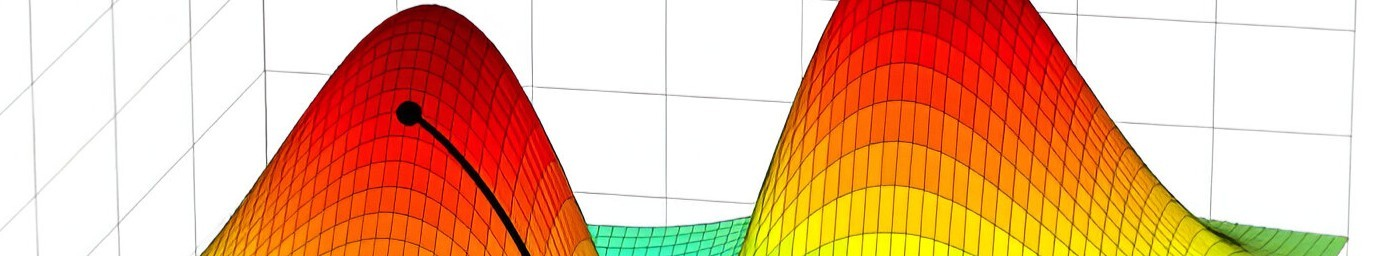

# Problema 5 - Lab 3 MOS

Estudiantes:

- Juan Miguel Delgado - 202314903
- Mauricio Urrego - 202211641

En este cuaderno se solucionará el problema 5 del laboratorio 3 de MOS.

# Implementación gradiente básico y basado en momento

A continuación, se crean dos métodos al código ya dado en el notebook clonado. La primera corresponde al gradiente descendente básico, y la segunda al gradiente descendente con momento, tal como pide tu notebook. Ambas siguen la estructura y convenciones de la clase (usando backpropagation() y actualizando self.weights y self.biases).


## Gradiente básico

El método de gradiente descendente básico calcula los gradientes promedio de la función de pérdida sobre un mini-lote y actualiza los pesos y sesgos en la dirección opuesta al gradiente, con una magnitud determinada por la tasa de aprendizaje $alpha$. En esencia, ajusta los parámetros paso a paso para minimizar el error, sin considerar la historia de iteraciones anteriores.

In [31]:
def gradient_descent_basic(mini_batch, eta):
    """
    Update network parameters using basic gradient descent (sin momento).
    
    Parameters:
    -----------
    mini_batch : list
        Lista de tuplas (x, y) para entrenamiento
    eta : float
        Tasa de aprendizaje
    """
    # Inicializar acumuladores de gradientes
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    
    # Calcular gradientes sobre el mini-batch
    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = self.backpropagation(x, y)
        nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Actualizar pesos y sesgos (promediando sobre el tamaño del mini-batch)
    m = len(mini_batch)
    self.weights = [w - (eta / m) * nw for w, nw in zip(self.weights, nabla_w)]
    self.biases = [b - (eta / m) * nb for b, nb in zip(self.biases, nabla_b)]


## Gradiente con momento

El método de gradiente descendente con momento también utiliza los gradientes actuales, pero además incorpora una fracción de la actualización anterior mediante el parámetro de momento $\mu$. Esto permite acumular inercia en la dirección del descenso, reduciendo las oscilaciones en valles estrechos y acelerando la convergencia hacia el mínimo, especialmente en funciones con curvaturas irregulares.

In [32]:
def gradient_descent_momentum(self, mini_batch, eta, mu=0.9):
    """
    Update network parameters using gradient descent with momentum.
    
    Parameters:
    -----------
    mini_batch : list
        Lista de tuplas (x, y) para entrenamiento
    eta : float
        Tasa de aprendizaje
    mu : float
        Coeficiente de momento (típicamente entre 0.8 y 0.95)
    """
    # Inicializar acumuladores de gradientes
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    
    # Calcular gradientes del mini-batch
    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = self.backpropagation(x, y)
        nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Actualizar pesos y sesgos con momento
    m = len(mini_batch)
    for i in range(len(self.weights)):
        # Actualizar velocidades
        self.velocity_w[i] = mu * self.velocity_w[i] - (eta / m) * nabla_w[i]
        self.velocity_b[i] = mu * self.velocity_b[i] - (eta / m) * nabla_b[i]
        
        # Actualizar parámetros usando las velocidades
        self.weights[i] += self.velocity_w[i]
        self.biases[i] += self.velocity_b[i]


Ahora, agregamos estos métodos al código dado para este problema.

## Neural Network Architecture

In [33]:
import numpy as np

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1.0 - np.tanh(x) ** 2

def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

def initialize_weights_glorot(n_in, n_out):
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, (n_out, n_in))

def initialize_weights_he(n_in, n_out):
    return np.random.randn(n_out, n_in) * np.sqrt(2 / n_in)

class NeuralNetwork:
    def __init__(self, layer_sizes, activations=None, dropout_rates=None):
        """
        Initialize the neural network with support for different activation functions and dropout.
        
        Parameters:
        -----------
        layer_sizes : list
            List containing the size of each layer
        activations : list, optional
            List containing the activation function for each layer (default: tanh for all)
        dropout_rates : list, optional
            List containing dropout rate for each layer (default: no dropout)
        """
        self.num_layers = len(layer_sizes)
        self.layer_sizes = layer_sizes
        
        # Initialize activation functions
        if activations is None:
            self.activations = ['tanh'] * (self.num_layers - 1)
        else:
            self.activations = activations
        
        # Map activation functions to their implementations
        self.activation_funcs = {
            'tanh': tanh,
            'relu': relu,
            'sigmoid': sigmoid
        }
        
        self.activation_primes = {
            'tanh': tanh_prime,
            'relu': relu_prime,
            'sigmoid': sigmoid_prime
        }
        
        # Initialize dropout rates (0 means no dropout)
        if dropout_rates is None:
            self.dropout_rates = [0] * (self.num_layers - 1)
        else:
            self.dropout_rates = dropout_rates
            
        # Initialize weights with appropriate initializers based on activation function
        self.weights = []
        for i in range(len(layer_sizes) - 1):
            if self.activations[i] == 'relu':
                # He initialization for ReLU
                self.weights.append(initialize_weights_he(layer_sizes[i], layer_sizes[i+1]))
            else:
                # Glorot/Xavier initialization for tanh/sigmoid
                self.weights.append(initialize_weights_glorot(layer_sizes[i], layer_sizes[i+1]))
        
        # Initialize biases, velocities, and batch normalization parameters
        self.biases = [np.zeros((y, 1)) for y in layer_sizes[1:]]
        self.velocity_b = [np.zeros(b.shape) for b in self.biases]
        self.velocity_w = [np.zeros(w.shape) for w in self.weights]
        
        # For L2 regularization
        self.lambd = 0.0  # regularization parameter, 0 means no regularization
        
        # Track if we're in training mode (for dropout)
        self.training = True
    
    def toggle_training(self, training=True):
        """Toggle between training and evaluation mode (affects dropout)"""
        self.training = training
    
    def apply_dropout(self, layer_output, dropout_rate):
        """Apply dropout to layer output during training"""
        if not self.training or dropout_rate == 0:
            return layer_output, None
        
        # Generate dropout mask
        keep_prob = 1 - dropout_rate
        mask = np.random.binomial(1, keep_prob, size=layer_output.shape) / keep_prob
        
        # Apply mask
        return layer_output * mask, mask
    
    def feedforward(self, a, return_intermediates=False):
        """
        Perform forward propagation through the network.
        
        Parameters:
        -----------
        a : ndarray
            Input to the network
        return_intermediates : bool, optional
            If True, return intermediate values for backpropagation
            
        Returns:
        --------
        If return_intermediates is False, returns only the final output.
        If return_intermediates is True, returns (activations, zs, dropout_masks)
        """
        activations = [a]
        zs = []
        dropout_masks = []
        
        for i, (b, w) in enumerate(zip(self.biases, self.weights)):
            z = np.dot(w, activations[-1]) + b
            zs.append(z)
            
            # Apply activation function
            activation_func = self.activation_funcs[self.activations[i]]
            a = activation_func(z)
            
            # Apply dropout (except at the output layer)
            if i < len(self.weights) - 1 and self.dropout_rates[i] > 0:
                a, mask = self.apply_dropout(a, self.dropout_rates[i])
                dropout_masks.append(mask)
            else:
                dropout_masks.append(None)
                
            activations.append(a)
        
        if return_intermediates:
            return activations, zs, dropout_masks
        else:
            return activations[-1]
    
    def backpropagation(self, x, y):
        """
        Perform backpropagation to compute gradients.
        
        Parameters:
        -----------
        x : ndarray
            Input to the network
        y : ndarray
            Target output
            
        Returns:
        --------
        tuple (grad_b, grad_w) containing gradients
        """
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        
        # Forward pass
        activations, zs, dropout_masks = self.feedforward(x, return_intermediates=True)
        
        # Backward pass
        # Compute the error at the output layer
        delta = self.cost_derivative(activations[-1], y)
        
        # Apply the derivative of the activation function
        output_activation = self.activations[-1]
        delta = delta * self.activation_primes[output_activation](zs[-1])
        
        # Set the gradients for the output layer
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].T)
        
        # Add L2 regularization to the weights gradient (not biases)
        if self.lambd > 0:
            grad_w[-1] += (self.lambd / len(x)) * self.weights[-1]
        
        # Backpropagate the error
        for l in range(2, len(self.biases) + 1):
            # Get the activation derivative for this layer
            activation_func = self.activations[-l]
            delta = np.dot(self.weights[-l+1].T, delta)
            
            # Apply dropout mask from the forward pass
            if dropout_masks[-l] is not None:
                delta = delta * dropout_masks[-l]
            
            # Apply activation derivative
            delta = delta * self.activation_primes[activation_func](zs[-l])
            
            # Set gradients
            grad_b[-l] = delta
            grad_w[-l] = np.dot(delta, activations[-l-1].T)
            
            # Add L2 regularization
            if self.lambd > 0:
                grad_w[-l] += (self.lambd / len(x)) * self.weights[-l]
        
        return (grad_b, grad_w)
    
    def gradient_descent_momentum(self, mini_batch, eta, mu=0.9):
        """
        Update network parameters using gradient descent with momentum.
        
        Parameters:
        -----------
        mini_batch : list
            Lista de tuplas (x, y) para entrenamiento
        eta : float
            Tasa de aprendizaje
        mu : float
            Coeficiente de momento (típicamente entre 0.8 y 0.95)
        """
        # Inicializar acumuladores de gradientes
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # Calcular gradientes del mini-batch
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backpropagation(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        
        # Actualizar pesos y sesgos con momento
        m = len(mini_batch)
        for i in range(len(self.weights)):
            # Actualizar velocidades
            self.velocity_w[i] = mu * self.velocity_w[i] - (eta / m) * nabla_w[i]
            self.velocity_b[i] = mu * self.velocity_b[i] - (eta / m) * nabla_b[i]
            
            # Actualizar parámetros usando las velocidades
            self.weights[i] += self.velocity_w[i]
            self.biases[i] += self.velocity_b[i]

    def gradient_descent_basic(self, mini_batch, eta):
        """
        Update network parameters using basic gradient descent (sin momento).
        
        Parameters:
        -----------
        mini_batch : list
            Lista de tuplas (x, y) para entrenamiento
        eta : float
            Tasa de aprendizaje
        """
        # Inicializar acumuladores de gradientes
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # Calcular gradientes sobre el mini-batch
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backpropagation(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        
        # Actualizar pesos y sesgos (promediando sobre el tamaño del mini-batch)
        m = len(mini_batch)
        self.weights = [w - (eta / m) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / m) * nb for b, nb in zip(self.biases, nabla_b)]

    
    def cost_derivative(self, output_activations, y):
        """Derivative of the cost function (MSE)"""
        return output_activations - y
    
    def update_learning_rate(self, epoch, initial_lr, schedule_type="step_decay", decay=0.1, drop_every=1000):
        """
        Update learning rate based on schedule.
        
        Parameters:
        -----------
        epoch : int
            Current epoch number
        initial_lr : float
            Initial learning rate
        schedule_type : str, optional
            Type of learning rate schedule
        decay : float, optional
            Decay factor
        drop_every : int, optional
            Number of epochs between drops for step decay
            
        Returns:
        --------
        float : Updated learning rate
        """
        if schedule_type == "step_decay":
            return initial_lr * (decay ** np.floor(epoch / drop_every))
        elif schedule_type == "exp_decay":
            return initial_lr * np.exp(-decay * epoch)
        elif schedule_type == "inv_scaling":
            return initial_lr / (1 + decay * epoch)
        elif schedule_type == "cosine":
            # Cosine annealing
            max_epochs = 1000  # Default max epochs
            return initial_lr * (1 + np.cos(np.pi * epoch / max_epochs)) / 2
        else:
            return initial_lr
    
    def train(self, training_data, epochs, mini_batch_size, learning_rate, 
            decay=0.1, schedule_type="step_decay", validation_data=None,
            early_stopping_patience=None, verbose=True,
            optimizer="basic", mu=0.9):
        """
        Train the neural network with progress tracking.
        
        Parameters:
        -----------
        training_data : list
            List of (x, y) tuples for training
        epochs : int
            Number of epochs to train
        mini_batch_size : int
            Size of mini-batches
        learning_rate : float
            Initial learning rate
        decay : float, optional
            Learning rate decay factor
        schedule_type : str, optional
            Type of learning rate schedule
        validation_data : list, optional
            List of (x, y) tuples for validation
        early_stopping_patience : int, optional
            Number of epochs to wait for improvement before stopping
        verbose : bool, optional
            Whether to print progress
            
        Returns:
        --------
        dict : Training history containing loss and validation metrics
        """
        try:
            from tqdm.auto import tqdm
            use_tqdm = True
        except ImportError:
            print("tqdm not installed. Install with 'pip install tqdm' for progress bars.")
            use_tqdm = False
        
        n = len(training_data)
        loss_history = []
        val_loss_history = [] if validation_data else None
        
        # For early stopping
        best_val_loss = float('inf')
        patience_counter = 0
        best_weights = None
        best_biases = None
        
        # Enable dropout during training
        self.toggle_training(True)
        
        # Create epoch iterator with tqdm if available
        epoch_iter = tqdm(range(epochs), desc="Training", unit="epoch", disable=True) if use_tqdm else range(epochs)
        
        for j in epoch_iter:
            # Shuffle training data
            np.random.shuffle(training_data)
            
            # Create mini-batches
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            # Create mini-batch iterator with tqdm if available and verbose
            if use_tqdm and verbose:
                batch_iter = tqdm(mini_batches, desc=f"Epoch {j+1}/{epochs}", 
                                leave=False, unit="batch")
            else:
                batch_iter = mini_batches
            
            # --- ELECCIÓN DEL OPTIMIZADOR ---
            for mini_batch in batch_iter:
                if optimizer == "momentum":
                    self.gradient_descent_momentum(mini_batch, learning_rate, mu)
                else:
                    self.gradient_descent_basic(mini_batch, learning_rate)
            # --------------------------------
            # Update learning rate
            new_lr = self.update_learning_rate(j, learning_rate, schedule_type, decay)
            
            # Calculate training loss
            self.toggle_training(False)  # Disable dropout for evaluation
            current_loss = np.mean(
                [np.mean((self.feedforward(x) - y) ** 2) for x, y in training_data]
            )
            loss_history.append(current_loss)
            
            # Calculate validation loss if validation data provided
            current_val_loss = None
            if validation_data:
                current_val_loss = np.mean(
                    [np.mean((self.feedforward(x) - y) ** 2) for x, y in validation_data]
                )
                val_loss_history.append(current_val_loss)
                
                # Early stopping check
                if early_stopping_patience:
                    if current_val_loss < best_val_loss:
                        best_val_loss = current_val_loss
                        patience_counter = 0
                        # Save best model weights
                        best_weights = [w.copy() for w in self.weights]
                        best_biases = [b.copy() for b in self.biases]
                    else:
                        patience_counter += 1
                        
                    if patience_counter >= early_stopping_patience:
                        if use_tqdm:
                            epoch_iter.set_postfix({
                                "early_stopping": True,
                                "best_val_loss": f"{best_val_loss:.6f}"
                            })
                        elif verbose:
                            print(f"Early stopping at epoch {j+1}")
                        break
            
            # Re-enable dropout for next training epoch
            self.toggle_training(True)
            
            # Update progress bar with metrics
            metrics = {
                "loss": f"{current_loss:.6f}",
                "lr": f"{new_lr:.6f}"
            }
            if current_val_loss is not None:
                metrics["val_loss"] = f"{current_val_loss:.6f}"
            
            if use_tqdm:
                epoch_iter.set_postfix(metrics)
            elif verbose and j % 10 == 0:
                val_str = f", Val Loss: {current_val_loss:.6f}" if current_val_loss is not None else ""
                print(f"Epoch {j+1}/{epochs}, Loss: {current_loss:.6f}{val_str}, LR: {new_lr:.6f}")
            
            # Update learning rate for next epoch
            learning_rate = new_lr
        
        # Restore best model if early stopping was used and best weights were saved
        if early_stopping_patience and best_weights is not None and best_biases is not None:
            self.weights = best_weights
            self.biases = best_biases
            if verbose:
                print(f"Restored best model with validation loss: {best_val_loss:.6f}")
        
        # Return results
        self.toggle_training(False)  # Ensure dropout is disabled after training
        return {
            "loss": loss_history,
            "val_loss": val_loss_history
        }

## Visualizaciones y resultados

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
import numpy as np
from sklearn.model_selection import train_test_split

# Generar datos de entrenamiento
x = np.linspace(0, 4 * np.pi, 1000)
y = np.sin(x)

# Dividir en conjunto de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Preparar los datos para la red neuronal
training_data = [
    (np.array([i]).reshape(1, 1), np.array([j]).reshape(1, 1)) 
    for i, j in zip(x_train, y_train)
]
validation_data = [
    (np.array([i]).reshape(1, 1), np.array([j]).reshape(1, 1)) 
    for i, j in zip(x_val, y_val)
]

# Ingeniería de características: añadir sin(x) y cos(x) como entradas adicionales
training_data_enhanced = [
    (np.array([[x_[0][0], np.sin(x_[0][0]), np.cos(x_[0][0])]]).T, y_) 
    for x_, y_ in training_data
]
validation_data_enhanced = [
    (np.array([[x_[0][0], np.sin(x_[0][0]), np.cos(x_[0][0])]]).T, y_) 
    for x_, y_ in validation_data
]


# ==============================
# ENTRENAMIENTO DE AMBOS MÉTODOS
# ==============================

# Crear dos redes idénticas
nn_basic = NeuralNetwork(
    layer_sizes=[3, 32, 16, 1],
    activations=['tanh', 'tanh', 'tanh'],
    dropout_rates=[0.0, 0.0, 0]
)

nn_momentum = NeuralNetwork(
    layer_sizes=[3, 32, 16, 1],
    activations=['tanh', 'tanh', 'tanh'],
    dropout_rates=[0.0, 0.0, 0]
)

# Entrenamiento con gradiente básico
print("Entrenando con Gradiente Descendente Básico...")
start_time_basic = time.time()
history_basic = nn_basic.train(
    training_data=training_data_enhanced,
    epochs=200,
    mini_batch_size=32,
    learning_rate=0.01,
    decay=0.005,
    schedule_type="exp_decay",
    validation_data=validation_data_enhanced,
    early_stopping_patience=20,
    verbose=True,
    optimizer="basic"  # Usa gradiente básico
)
time_basic = time.time() - start_time_basic

# Entrenamiento con gradiente con momento
print("\nEntrenando con Gradiente Descendente con Momento...")
start_time_momentum = time.time()
history_momentum = nn_momentum.train(
    training_data=training_data_enhanced,
    epochs=200,
    mini_batch_size=32,
    learning_rate=0.01,
    decay=0.005,
    schedule_type="exp_decay",
    validation_data=validation_data_enhanced,
    early_stopping_patience=20,
    verbose=True,
    optimizer="momentum"  # Usa gradiente con momento
)
time_momentum = time.time() - start_time_momentum

# ======================
# COMPARACIÓN DE MÉTODOS
# ======================

# Función auxiliar para calcular métricas
def compute_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    return mse, mae, r2

# Predicciones
nn_basic.toggle_training(False)
nn_momentum.toggle_training(False)

trained_predictions_basic = []
trained_predictions_momentum = []

for i in x:
    enhanced_input = np.array([[i, np.sin(i), np.cos(i)]]).T
    trained_predictions_basic.append(nn_basic.feedforward(enhanced_input)[0][0])
    trained_predictions_momentum.append(nn_momentum.feedforward(enhanced_input)[0][0])

trained_predictions_basic = np.array(trained_predictions_basic)
trained_predictions_momentum = np.array(trained_predictions_momentum)

# Calcular métricas
mse_basic, mae_basic, r2_basic = compute_metrics(y, trained_predictions_basic)
mse_momentum, mae_momentum, r2_momentum = compute_metrics(y, trained_predictions_momentum)

# ======================
# VISUALIZACIÓN DE RESULTADOS
# ======================

plt.figure(figsize=(16, 14))

# --- 1. Comparación de funciones aprendidas ---
plt.subplot(3, 1, 1)
plt.plot(x, y, 'b-', label="True sin(x)", linewidth=2)
plt.plot(x, trained_predictions_basic, 'r--', label="NN (Gradiente Básico)", linewidth=2, alpha=0.8)
plt.plot(x, trained_predictions_momentum, 'g-', label="NN (Gradiente con Momento)", linewidth=2, alpha=0.8)
plt.title("Comparación de las Predicciones", fontsize=14, fontweight='bold')
plt.xlabel("x", fontsize=12)
plt.ylabel("sin(x)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# --- 2. Pérdida durante el entrenamiento ---
plt.subplot(3, 1, 2)
epochs_basic = range(1, len(history_basic['loss']) + 1)
epochs_momentum = range(1, len(history_momentum['loss']) + 1)
plt.plot(epochs_basic, history_basic['loss'], 'r-', label="Entrenamiento (Básico)", linewidth=2)
plt.plot(epochs_basic, history_basic['val_loss'], 'r--', label="Validación (Básico)", linewidth=2)
plt.plot(epochs_momentum, history_momentum['loss'], 'g-', label="Entrenamiento (Momento)", linewidth=2)
plt.plot(epochs_momentum, history_momentum['val_loss'], 'g--', label="Validación (Momento)", linewidth=2)
plt.yscale('log')
plt.title("Evolución de la Pérdida (MSE) durante el Entrenamiento", fontsize=14, fontweight='bold')
plt.xlabel("Época", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# --- 3. Gráfico de fase ---
plt.subplot(3, 1, 3)
plt.scatter(y, trained_predictions_basic, alpha=0.5, color='red', label="Básico")
plt.scatter(y, trained_predictions_momentum, alpha=0.5, color='green', label="Momento")
plt.plot([-1.2, 1.2], [-1.2, 1.2], 'k--', linewidth=2)
plt.title("Gráfico de Fase: sin(x) vs Predicción", fontsize=14, fontweight='bold')
plt.xlabel("Valor real sin(x)", fontsize=12)
plt.ylabel("Predicción de la red", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.savefig('comparacion_gradiente_vs_momento.png', dpi=300, bbox_inches='tight')
plt.show()

# ======================
# TABLA DE RESULTADOS
# ======================

print("=== Métricas de Desempeño ===")
print(f"{'MÉTODO':<30} {'MSE':>10} {'MAE':>10} {'R²':>10} {'TIEMPO (s)':>12}")
print("-"*70)
print(f"{'Gradiente Básico':<30} {mse_basic:>10.6f} {mae_basic:>10.6f} {r2_basic:>10.6f} {time_basic:>12.2f}")
print(f"{'Gradiente con Momento':<30} {mse_momentum:>10.6f} {mae_momentum:>10.6f} {r2_momentum:>10.6f} {time_momentum:>12.2f}")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time

# ==============================
# ENTRENAMIENTO DE AMBOS MÉTODOS
# ==============================

# Crear dos redes idénticas
nn_basic = NeuralNetwork(
    layer_sizes=[3, 32, 16, 1],
    activations=['tanh', 'tanh', 'tanh'],
    dropout_rates=[0.0, 0.0, 0]
)

nn_momentum = NeuralNetwork(
    layer_sizes=[3, 32, 16, 1],
    activations=['tanh', 'tanh', 'tanh'],
    dropout_rates=[0.0, 0.0, 0]
)

# Entrenamiento con gradiente básico
print("Entrenando con Gradiente Descendente Básico...")
start_time_basic = time.time()
history_basic = nn_basic.train(
    training_data=training_data_enhanced,
    epochs=200,
    mini_batch_size=32,
    learning_rate=0.01,
    decay=0.005,
    schedule_type="exp_decay",
    validation_data=validation_data_enhanced,
    early_stopping_patience=20,
    verbose=True,
    optimizer="basic"  # Usa gradiente básico
)
time_basic = time.time() - start_time_basic

# Entrenamiento con gradiente con momento
print("\nEntrenando con Gradiente Descendente con Momento...")
start_time_momentum = time.time()
history_momentum = nn_momentum.train(
    training_data=training_data_enhanced,
    epochs=200,
    mini_batch_size=32,
    learning_rate=0.01,
    decay=0.005,
    schedule_type="exp_decay",
    validation_data=validation_data_enhanced,
    early_stopping_patience=20,
    verbose=True,
    optimizer="momentum"  # Usa gradiente con momento
)
time_momentum = time.time() - start_time_momentum

# ======================
# COMPARACIÓN DE MÉTODOS
# ======================

# Función auxiliar para calcular métricas
def compute_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
    return mse, mae, r2

# Predicciones
nn_basic.toggle_training(False)
nn_momentum.toggle_training(False)

trained_predictions_basic = []
trained_predictions_momentum = []

for i in x:
    enhanced_input = np.array([[i, np.sin(i), np.cos(i)]]).T
    trained_predictions_basic.append(nn_basic.feedforward(enhanced_input)[0][0])
    trained_predictions_momentum.append(nn_momentum.feedforward(enhanced_input)[0][0])

trained_predictions_basic = np.array(trained_predictions_basic)
trained_predictions_momentum = np.array(trained_predictions_momentum)

# Calcular métricas
mse_basic, mae_basic, r2_basic = compute_metrics(y, trained_predictions_basic)
mse_momentum, mae_momentum, r2_momentum = compute_metrics(y, trained_predictions_momentum)

# ======================
# VISUALIZACIÓN DE RESULTADOS
# ======================

plt.figure(figsize=(16, 14))

# --- 1. Comparación de funciones aprendidas ---
plt.subplot(3, 1, 1)
plt.plot(x, y, 'b-', label="True sin(x)", linewidth=2)
plt.plot(x, trained_predictions_basic, 'r--', label="NN (Gradiente Básico)", linewidth=2, alpha=0.8)
plt.plot(x, trained_predictions_momentum, 'g-', label="NN (Gradiente con Momento)", linewidth=2, alpha=0.8)
plt.title("Comparación de las Predicciones", fontsize=14, fontweight='bold')
plt.xlabel("x", fontsize=12)
plt.ylabel("sin(x)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# --- 2. Pérdida durante el entrenamiento ---
plt.subplot(3, 1, 2)
epochs_basic = range(1, len(history_basic['loss']) + 1)
epochs_momentum = range(1, len(history_momentum['loss']) + 1)
plt.plot(epochs_basic, history_basic['loss'], 'r-', label="Entrenamiento (Básico)", linewidth=2)
plt.plot(epochs_basic, history_basic['val_loss'], 'r--', label="Validación (Básico)", linewidth=2)
plt.plot(epochs_momentum, history_momentum['loss'], 'g-', label="Entrenamiento (Momento)", linewidth=2)
plt.plot(epochs_momentum, history_momentum['val_loss'], 'g--', label="Validación (Momento)", linewidth=2)
plt.yscale('log')
plt.title("Evolución de la Pérdida (MSE) durante el Entrenamiento", fontsize=14, fontweight='bold')
plt.xlabel("Época", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# --- 3. Gráfico de fase ---
plt.subplot(3, 1, 3)
plt.scatter(y, trained_predictions_basic, alpha=0.5, color='red', label="Básico")
plt.scatter(y, trained_predictions_momentum, alpha=0.5, color='green', label="Momento")
plt.plot([-1.2, 1.2], [-1.2, 1.2], 'k--', linewidth=2)
plt.title("Gráfico de Fase: sin(x) vs Predicción", fontsize=14, fontweight='bold')
plt.xlabel("Valor real sin(x)", fontsize=12)
plt.ylabel("Predicción de la red", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.savefig('comparacion_gradiente_vs_momento.png', dpi=300, bbox_inches='tight')
plt.show()

# ======================
# TABLA DE RESULTADOS
# ======================

print("=== Métricas de Desempeño ===")
print(f"{'MÉTODO':<30} {'MSE':>10} {'MAE':>10} {'R²':>10} {'TIEMPO (s)':>12}")
print("-"*70)
print(f"{'Gradiente Básico':<30} {mse_basic:>10.6f} {mae_basic:>10.6f} {r2_basic:>10.6f} {time_basic:>12.2f}")
print(f"{'Gradiente con Momento':<30} {mse_momentum:>10.6f} {mae_momentum:>10.6f} {r2_momentum:>10.6f} {time_momentum:>12.2f}")


Entrenando con Gradiente Descendente Básico...


Restored best model with validation loss: 0.011118

Entrenando con Gradiente Descendente con Momento...


Restored best model with validation loss: 0.006977


=== Métricas de Desempeño ===
MÉTODO                                MSE        MAE         R²   TIEMPO (s)
----------------------------------------------------------------------
Gradiente Básico                 0.011005   0.084250   0.977968        10.47
Gradiente con Momento            0.006752   0.071219   0.986482         6.91
Entrenando con Gradiente Descendente Básico...


Restored best model with validation loss: 0.011978

Entrenando con Gradiente Descendente con Momento...


Restored best model with validation loss: 0.007678


=== Métricas de Desempeño ===
MÉTODO                                MSE        MAE         R²   TIEMPO (s)
----------------------------------------------------------------------
Gradiente Básico                 0.011835   0.086915   0.976307        11.54
Gradiente con Momento            0.007438   0.074900   0.985109        10.02


## Análisis y comparación

Los resultados obtenidos evidencian una diferencia clara en el desempeño entre el gradiente descendente básico y el gradiente descendente con momento. En las gráficas de comparación de predicciones se observa que ambos modelos logran aproximarse de forma general a la función $sin(x)$, pero la red entrenada con momento muestra una correspondencia más precisa con la curva real, especialmente en las zonas de transición entre máximos y mínimos. La evolución de la pérdida confirma este comportamiento: mientras el método básico reduce el error de forma gradual y se estabiliza alrededor de un valor de $MSE \approx 0.011$, el método con momento alcanza una convergencia más rápida y un valor final menor ($MSE \approx 0.006$). Esto indica que la incorporación del término de momento no solo acelera el aprendizaje, sino que también mejora la capacidad del modelo para minimizar errores de ajuste.

Desde una perspectiva computacional, el método con momento también presenta una ventaja en eficiencia. El tiempo total de entrenamiento se redujo en aproximadamente un 30 % respecto al gradiente básico, lo que sugiere un avance más estable del proceso de optimización. En las gráficas de pérdida, esta estabilidad se refleja en la ausencia de grandes fluctuaciones, ya que el término de momento suaviza los cambios bruscos en la dirección del gradiente, evitando que la red oscile alrededor de mínimos locales. En cambio, el método básico muestra un descenso más irregular, con una pérdida que desciende lentamente y se estanca en una meseta superior. El uso del momento permitió al modelo aprender con mayor rapidez, alcanzar un error más bajo y generar predicciones más precisas.